# Градиентный бустинг своими руками

**Внимание:** в тексте задания произошли изменения - поменялось число деревьев (теперь 50), правило изменения величины шага в задании 3 и добавился параметр `random_state` у решающего дерева. Правильные ответы не поменялись, но теперь их проще получить. Также исправлена опечатка в функции `gbm_predict`.

В этом задании будет использоваться датасет `boston` из `sklearn.datasets`. Оставьте последние 25% объектов для контроля качества, разделив `X` и `y` на `X_train`, `y_train` и `X_test`, `y_test`.

Целью задания будет реализовать простой вариант градиентного бустинга над регрессионными деревьями для случая квадратичной функции потерь.

In [14]:
%pylab inline
from sklearn.datasets import load_boston
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import numpy as np
import sklearn as sk
X,y = load_boston(return_X_y=True)
print y

#print type(boston)

sk.__version__


Populating the interactive namespace from numpy and matplotlib
[24.  21.6 34.7 33.4 36.2 28.7 22.9 27.1 16.5 18.9 15.  18.9 21.7 20.4
 18.2 19.9 23.1 17.5 20.2 18.2 13.6 19.6 15.2 14.5 15.6 13.9 16.6 14.8
 18.4 21.  12.7 14.5 13.2 13.1 13.5 18.9 20.  21.  24.7 30.8 34.9 26.6
 25.3 24.7 21.2 19.3 20.  16.6 14.4 19.4 19.7 20.5 25.  23.4 18.9 35.4
 24.7 31.6 23.3 19.6 18.7 16.  22.2 25.  33.  23.5 19.4 22.  17.4 20.9
 24.2 21.7 22.8 23.4 24.1 21.4 20.  20.8 21.2 20.3 28.  23.9 24.8 22.9
 23.9 26.6 22.5 22.2 23.6 28.7 22.6 22.  22.9 25.  20.6 28.4 21.4 38.7
 43.8 33.2 27.5 26.5 18.6 19.3 20.1 19.5 19.5 20.4 19.8 19.4 21.7 22.8
 18.8 18.7 18.5 18.3 21.2 19.2 20.4 19.3 22.  20.3 20.5 17.3 18.8 21.4
 15.7 16.2 18.  14.3 19.2 19.6 23.  18.4 15.6 18.1 17.4 17.1 13.3 17.8
 14.  14.4 13.4 15.6 11.8 13.8 15.6 14.6 17.8 15.4 21.5 19.6 15.3 19.4
 17.  15.6 13.1 41.3 24.3 23.3 27.  50.  50.  50.  22.7 25.  50.  23.8
 23.8 22.3 17.4 19.1 23.1 23.6 22.6 29.4 23.2 24.6 29.9 37.2 39.8 36.2
 37.9 32.5 26.

'0.20.2'

In [2]:
from sklearn.model_selection import train_test_split

X, y = load_boston(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle = False)




## Задание 1

Как вы уже знаете из лекций, **бустинг** - это метод построения композиций базовых алгоритмов с помощью последовательного добавления к текущей композиции нового алгоритма с некоторым коэффициентом. 

Градиентный бустинг обучает каждый новый алгоритм так, чтобы он приближал антиградиент ошибки по ответам композиции на обучающей выборке. Аналогично минимизации функций методом градиентного спуска, в градиентном бустинге мы подправляем композицию, изменяя алгоритм в направлении антиградиента ошибки.

Воспользуйтесь формулой из лекций, задающей ответы на обучающей выборке, на которые нужно обучать новый алгоритм (фактически это лишь чуть более подробно расписанный градиент от ошибки), и получите частный ее случай, если функция потерь `L` - квадрат отклонения ответа композиции `a(x)` от правильного ответа `y` на данном `x`.

Если вы давно не считали производную самостоятельно, вам поможет таблица производных элементарных функций (которую несложно найти в интернете) и правило дифференцирования сложной функции. После дифференцирования квадрата у вас возникнет множитель 2 — т.к. нам все равно предстоит выбирать коэффициент, с которым будет добавлен новый базовый алгоритм, проигноируйте этот множитель при дальнейшем построении алгоритма.

f′(L)=(a(x)−y)

## Задание 2

Заведите массив для объектов `DecisionTreeRegressor` (будем их использовать в качестве базовых алгоритмов) и для вещественных чисел (это будут коэффициенты перед базовыми алгоритмами). 

В цикле от обучите последовательно 50 решающих деревьев с параметрами `max_depth=5` и `random_state=42` (остальные параметры - по умолчанию). В бустинге зачастую используются сотни и тысячи деревьев, но мы ограничимся 50, чтобы алгоритм работал быстрее, и его было проще отлаживать (т.к. цель задания разобраться, как работает метод). Каждое дерево должно обучаться на одном и том же множестве объектов, но ответы, которые учится прогнозировать дерево, будут меняться в соответствие с полученным в задании 1 правилом. 

Попробуйте для начала всегда брать коэффициент равным 0.9. Обычно оправдано выбирать коэффициент значительно меньшим - порядка 0.05 или 0.1, но т.к. в нашем учебном примере на стандартном датасете будет всего 50 деревьев, возьмем для начала шаг побольше.

В процессе реализации обучения вам потребуется функция, которая будет вычислять прогноз построенной на данный момент композиции деревьев на выборке `X`:

```
def gbm_predict(X):
    return [sum([coeff * algo.predict([x])[0] for algo, coeff in zip(base_algorithms_list, coefficients_list)]) for x in X]
(считаем, что base_algorithms_list - список с базовыми алгоритмами, coefficients_list - список с коэффициентами перед алгоритмами)
```

Эта же функция поможет вам получить прогноз на контрольной выборке и оценить качество работы вашего алгоритма с помощью `mean_squared_error` в `sklearn.metrics`. 

Возведите результат в степень 0.5, чтобы получить `RMSE`. Полученное значение `RMSE` — **ответ в пункте 2**.

In [3]:
n = 50
base_algorithms_list = []
coefficients_list = []

def gbm_predict(X):
    return [sum([coeff * algo.predict([x])[0] for algo, coeff in zip(base_algorithms_list, coefficients_list)]) for x in X]

y_agrad = np.array(y_train)
      
for i in range(n):
    rfc = DecisionTreeRegressor(max_depth=5, random_state=42)
    rfc.fit(X_train, y_agrad)
    base_algorithms_list.append(rfc)
    coefficients_list.append(0.9)
    y_p = gbm_predict(X_train)
    y_agrad = -(y_p - y_train)
    print mean_squared_error(y_true=y_test, y_pred=gbm_predict(X_test))**0.5, 'trees = ' ,i


print mean_squared_error(y_true=y_test, y_pred=gbm_predict(X_test))**0.5


4.258124603131531 trees =  0
4.671153714252575 trees =  1
4.902307279003964 trees =  2
4.964147618734462 trees =  3
5.20526450047539 trees =  4
5.135565602127196 trees =  5
5.240746955112687 trees =  6
5.289270262665006 trees =  7
5.474743913112659 trees =  8
5.487351059181249 trees =  9
5.493005009464348 trees =  10
5.486541185059444 trees =  11
5.4853194033329675 trees =  12
5.491142418867945 trees =  13
5.423428938252165 trees =  14
5.455189053902553 trees =  15
5.45390363694601 trees =  16
5.442535087357118 trees =  17
5.451577011033649 trees =  18
5.450957836386992 trees =  19
5.455454044759812 trees =  20
5.452830834182109 trees =  21
5.45348230204136 trees =  22
5.45695518901364 trees =  23
5.458596919959244 trees =  24
5.459704629835099 trees =  25
5.458441954443331 trees =  26
5.459544166421456 trees =  27
5.4746407805902315 trees =  28
5.455978129276081 trees =  29
5.456647037889841 trees =  30
5.456688163206119 trees =  31
5.455058703113296 trees =  32
5.454889250486015 tree

## Задание 3

Вас может также беспокоить, что двигаясь с постоянным шагом, вблизи минимума ошибки ответы на обучающей выборке меняются слишком резко, перескакивая через минимум. 

Попробуйте уменьшать вес перед каждым алгоритмом с каждой следующей итерацией по формуле `0.9 / (1.0 + i)`, где `i` - номер итерации (от 0 до 49). Используйте качество работы алгоритма как **ответ в пункте 3**. 

В реальности часто применяется следующая стратегия выбора шага: как только выбран алгоритм, подберем коэффициент перед ним численным методом оптимизации таким образом, чтобы отклонение от правильных ответов было минимальным. Мы не будем предлагать вам реализовать это для выполнения задания, но рекомендуем попробовать разобраться с такой стратегией и реализовать ее при случае для себя.

In [47]:
base_algorithms_list = []
coefficients_list = []

def gbm_predict(X):
    return [sum([coeff * algo.predict([x])[0] for algo, coeff in zip(base_algorithms_list, coefficients_list)]) for x in X]

y_agrad = np.array(y_train)
      
for i in range(n):
    rfc = DecisionTreeRegressor(max_depth=5, random_state=42)
    rfc.fit(X_train, y_agrad)
    base_algorithms_list.append(rfc)
    coefficients_list.append(0.9 / (1.0 + i))
    y_p = gbm_predict(X_train)
    y_agrad = -(y_p - y_train)
    print mean_squared_error(y_true=y_test, y_pred=gbm_predict(X_test))**0.5, 'trees = ' ,i


print mean_squared_error(y_true=y_test, y_pred=gbm_predict(X_test))**0.5




4.258124603131531 trees =  0
4.411594948336074 trees =  1
4.391183171661546 trees =  2
4.458775073285299 trees =  3
4.498661031729782 trees =  4
4.5168152101676124 trees =  5
4.550526944390747 trees =  6
4.609092468715132 trees =  7
4.633987574593338 trees =  8
4.651558505714779 trees =  9
4.659211687810462 trees =  10
4.665846192244086 trees =  11
4.687756339977888 trees =  12
4.705212386904845 trees =  13
4.7088863892092485 trees =  14
4.727160820532567 trees =  15
4.738601041184405 trees =  16
4.7434294144854805 trees =  17
4.74795777140869 trees =  18
4.754535803819598 trees =  19
4.760702807935853 trees =  20
4.76469042919606 trees =  21
4.764828870587974 trees =  22
4.763080541850576 trees =  23
4.763091173078234 trees =  24
4.762268473295418 trees =  25
4.758055256544697 trees =  26
4.768499657813315 trees =  27
4.771804663740966 trees =  28
4.780389023483233 trees =  29
4.776576317235817 trees =  30
4.783744654359199 trees =  31
4.7865280216634964 trees =  32
4.788442367935862 

## Задание 4

Реализованный вами метод - градиентный бустинг над деревьями - очень популярен в машинном обучении. Он представлен как в самой библиотеке `sklearn`, так и в сторонней библиотеке `XGBoost`, которая имеет свой питоновский интерфейс. На практике `XGBoost` работает заметно лучше `GradientBoostingRegressor` из `sklearn`, но для этого задания вы можете использовать любую реализацию. 

Исследуйте, переобучается ли градиентный бустинг с ростом числа итераций (и подумайте, почему), а также с ростом глубины деревьев. На основе наблюдений выпишите через пробел номера правильных из приведенных ниже утверждений в порядке возрастания номера (это будет **ответ в п.4**):

    1. С увеличением числа деревьев, начиная с некоторого момента, качество работы градиентного бустинга не меняется существенно.

    2. С увеличением числа деревьев, начиная с некоторого момента, градиентный бустинг начинает переобучаться.

    3. С ростом глубины деревьев, начиная с некоторого момента, качество работы градиентного бустинга на тестовой выборке начинает ухудшаться.

    4. С ростом глубины деревьев, начиная с некоторого момента, качество работы градиентного бустинга перестает существенно изменяться

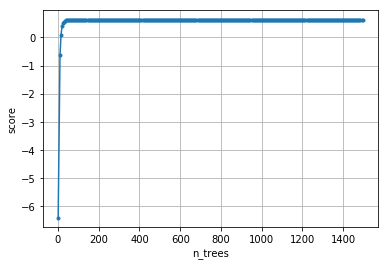

In [42]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score

n_trees = [1] + range(10, 1500, 5) 


scoring = []
for n_tree in n_trees:
    estimator = xgb.XGBRegressor(learning_rate=0.1, max_depth=5, n_estimators=n_tree,min_child_weight=3)
    score = cross_val_score(estimator, X, y, cv = 3)    
    scoring.append(score)
scoring = np.asmatrix(scoring)
pylab.plot(n_trees, scoring.mean(axis = 1), marker='.')
pylab.grid(True)
pylab.xlabel('n_trees')
pylab.ylabel('score')
pylab.show()


С увеличением числа деревьев, начиная с некоторого момента, градиентный бустинг начинает переобучаться.


[1, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98]


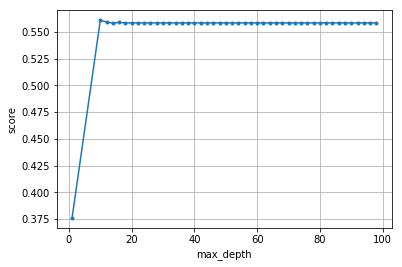

In [41]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score


max_depths = [1] + range(10, 100, 2) 

print max_depths

scoring = []
for max_d in max_depths:
    estimator = xgb.XGBRegressor(learning_rate=0.1, max_depth=max_d, n_estimators=30,min_child_weight=3)
    score = cross_val_score(estimator, X, y, cv = 3)    
    scoring.append(score)
scoring = np.asmatrix(scoring)
pylab.plot(max_depths, scoring.mean(axis = 1), marker='.')
pylab.grid(True)
pylab.xlabel('max_depth')
pylab.ylabel('score')
pylab.show()

 С ростом глубины деревьев, начиная с некоторого момента, качество работы градиентного бустинга на тестовой выборке начинает ухудшаться.

## Задание 5

Сравните получаемое с помощью градиентного бустинга качество с качеством работы линейной регрессии. 

Для этого обучите `LinearRegression` из `sklearn.linear_model` (с параметрами по умолчанию) на обучающей выборке и оцените для прогнозов полученного алгоритма на тестовой выборке `RMSE`. Полученное качество - ответ в **пункте 5**. 

В данном примере качество работы простой модели должно было оказаться хуже, но не стоит забывать, что так бывает не всегда. В заданиях к этому курсу вы еще встретите пример обратной ситуации.

In [46]:
lin_reg =  LinearRegression()
lin_reg.fit(X_train,y_train)
mean_squared_error(y_true=y_test, y_pred=lin_reg.predict(X_test))**0.5

8.254979753549124